More detail to be found in https://github.com/UPOD-datascience/toy_problems/

In [2]:
import sys
sys.path.append('/Users/Danial/Repos/ml')
import pandas as pd
import numpy as np
from src.pipe_store import (
    set_dtypes,
    sklearn_adapter
)
from src.feature_selection import plot_correlations
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [4]:
df= pd.DataFrame(data.data, columns=data.feature_names)
df['Y'] = data.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
X, y = (df
    .pipe(sklearn_adapter, label='Y')
)

In [6]:
df['Y'].value_counts()

1    357
0    212
Name: Y, dtype: int64

# Feature Selection and multi-colinearity

With a threshold of 0.7 S3 & S4 are colinear

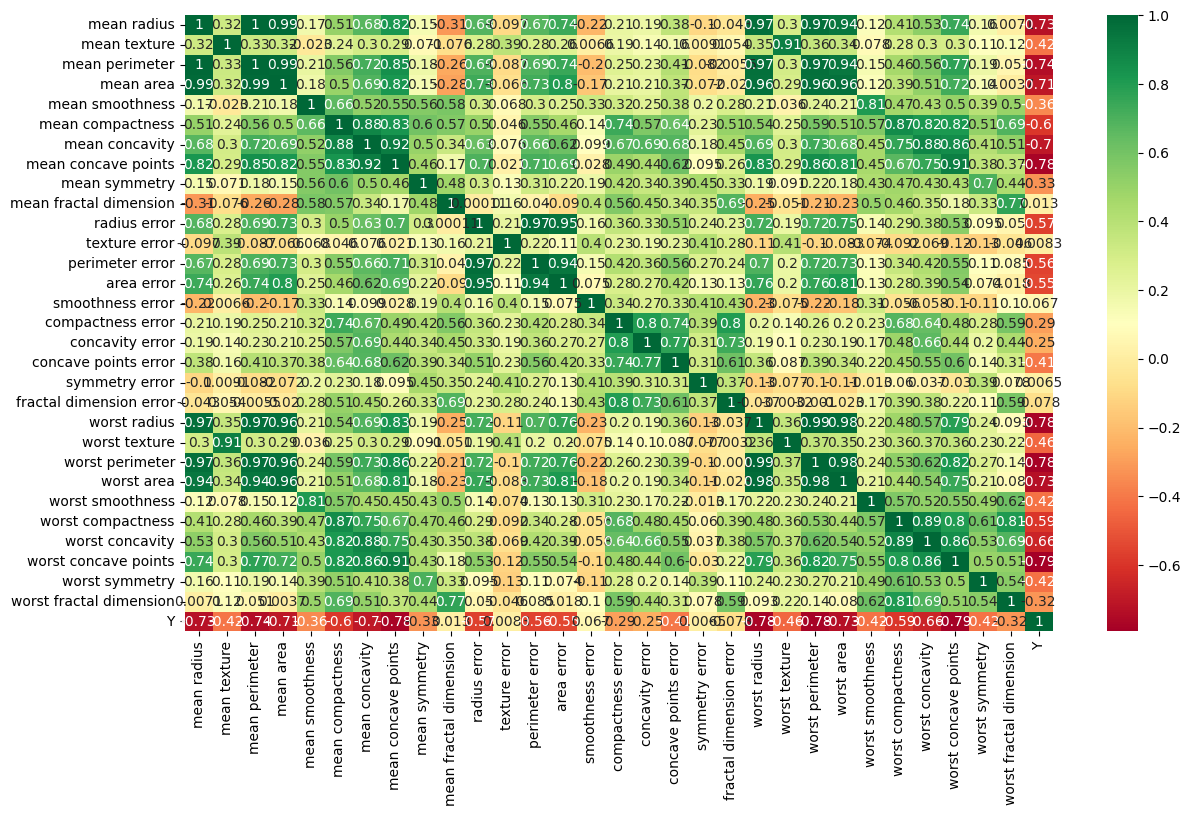

Top Correlations above 0.8
mean radius          mean perimeter             0.997855
worst radius         worst perimeter            0.993708
mean radius          mean area                  0.987357
mean perimeter       mean area                  0.986507
worst radius         worst area                 0.984015
worst perimeter      worst area                 0.977578
radius error         perimeter error            0.972794
mean perimeter       worst perimeter            0.970387
mean radius          worst radius               0.969539
mean perimeter       worst radius               0.969476
mean radius          worst perimeter            0.965137
mean area            worst radius               0.962746
                     worst area                 0.959213
                     worst perimeter            0.959120
radius error         area error                 0.951830
mean perimeter       worst area                 0.941550
mean radius          worst area                 0.941082
peri

In [7]:
top = plot_correlations(df)

In [7]:
top[30:60]

mean concave points  worst radius               0.830318
mean area            mean concave points        0.823269
mean radius          mean concave points        0.822529
worst perimeter      worst concave points       0.816322
mean compactness     worst concavity            0.816275
                     worst concave points       0.815573
area error           worst area                 0.811408
worst compactness    worst fractal dimension    0.810455
mean concave points  worst area                 0.809630
mean smoothness      worst smoothness           0.805324
compactness error    fractal dimension error    0.803269
                     concavity error            0.801268
worst compactness    worst concave points       0.801080
mean area            area error                 0.800086
dtype: float64

In [9]:
from collections import  defaultdict
jes = defaultdict(set)

for i, j in top.index:
    jes[i].add(j)

In [10]:
import networkx as nx
from pyvis.network import Network
G = nx.Graph()
G.add_nodes_from(jes.keys())
for node, neighbours in jes.items():
        G.add_edges_from(([(node, neighbour) for neighbour in neighbours]))
net = Network(notebook=True, cdn_resources='remote')
net.from_nx(G)
net.show("example.html");

In [16]:
selected_features = ['mean radius', 'area error', 'mean compactness', 'mean smoothness', 'mean texture']

## Supervised Feature Selection

### Univariate Feature Selection

In [ ]:
from sklearn.feature_selection import  SelectKBest, mutual_info_classif, f_classif
# cor, pvals = f_regression(X, y)
# pd.DataFrame([cor, pvals]).T
# print(mutual_info_regression(X, y))
X, y = sklearn_adapter(df, label="Y")

print(SelectKBest(f_classif, k=10).fit(X, y).get_feature_names_out())
print(SelectKBest(mutual_info_classif, k=10).fit(X, y).get_feature_names_out())

### Model based Feature selection

## Unsupervised Feature Selection

In [ ]:
## Supervised Feature Selection

In [ ]:
from sklearn.ensemble import IsolationForest
contamination = 0.3
data = df.drop('Y', axis=1).T
model = IsolationForest(contamination=contamination, n_estimators=200, verbose=1)
model.fit(data)
pred = model.predict(data)
feature = pd.DataFrame(data.index.values, columns=['features'])
feature['relevance'] = pd.Series(pred).map({1 : 0, -1 : 1})
feature
# mean area, mean perimeter, worst area, worst perimeter, worst texture, area error, mean texture, worst redius

In [ ]:
df

# Model Building

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = selected_features
X, y = df[selected_features], df['Y']

column_transformer_scaler = ColumnTransformer([
    ('Scaler', StandardScaler(), num_cols), 
], remainder='passthrough')


In [20]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
random_state = 42

regs = [ LogisticRegression(), RandomForestClassifier()]


results = {}
for reg in regs:

    pipeline = Pipeline([
        ('Scaling', column_transformer_scaler),
        ('Model', reg),
    ], verbose=False)

    kfs = KFold(n_splits=5, shuffle=True, random_state=random_state)
    # For the list of all metrics visit: https://scikit-learn.org/stable/modules/model_evaluation.html
    metrics = ['recall', 'roc_auc', 'accuracy', 'f1'] 
    scores = cross_validate(pipeline, X, y, cv=kfs, scoring=metrics)
    # We will not use cross_val_score as it can only accept one metric
    # print(scores)
    reg_name = type(reg).__name__
    results[reg_name] = {key: round(np.mean(val), 3) for key, val in scores.items()}
pd.DataFrame(results)

,LogisticRegression,RandomForestClassifier
fit_time,0.020,0.157
score_time,0.009,0.026
test_recall,0.958,0.955
test_roc_auc,0.982,0.982
test_accuracy,0.923,0.935
test_f1,0.939,0.948
